Define the weather station IDs we're interested in, that are near PSCO territory (which is discontinuous, unfortunately)

In [1]:
psco_station_ids = [
    "USW00023066"  # Grand Junction Walker Field
    "USC00053553",  # Greeley UNC
    "USC00053005",  # Ft Collins
    "USC00050848",  # Boulder
    "USC00055984",  # Northglenn
    "USC00058995",  # Wheat Ridge
    "USW00023061"  # Alamosa
]

Download daily data for each station

In [2]:
import requests

BASE_URL = "https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/all"

for station_id in psco_station_ids:
    dly_name = f"{station_id}.dly"
    station_url = f"{BASE_URL}/{dly_name}"
    print(f"Downloading {station_url}...")
    resp = requests.get(url=station_url, timeout=120)
    with open(f"ghcnd/station_data/{dly_name}", "w", encoding="utf-8") as f:
        f.write(resp.text)

Parse station observations data 

In [2]:
import os
from ghcnd.station_observations import read_from_dly_file

station_data_dir = "./ghcnd/station_data"
station_data = [read_from_dly_file(os.path.join(station_data_dir, f)) for f in os.listdir(station_data_dir)]

first_station = station_data[0]
first_station_obs = first_station.observations[0]
print(f"{first_station.station_id}: {first_station_obs.date} tmax={first_station_obs.tmax} tmin={first_station_obs.tmin}")


USC00050848: 2015-01-01 tmax=0 tmin=-144


Import station observations data in Pandas DataFrame

In [74]:
import pandas as pd
import matplotlib as plt
from datetime import date

obs = station_data[0].observations

df = pd.DataFrame(obs)
df["date"] = pd.to_datetime(df["date"])
df = df.assign(day_of_year=lambda x: x["date"].dt.day_of_year)

df.set_index("date", inplace=True)

df = df.interpolate(method="time")

df = df.assign(
    tmax_decimal=lambda x: x["tmax"] / 10.0,
    tmin_decimal=lambda x: x["tmin"] / 10.0)

Plot temp min/max

<AxesSubplot: xlabel='date'>

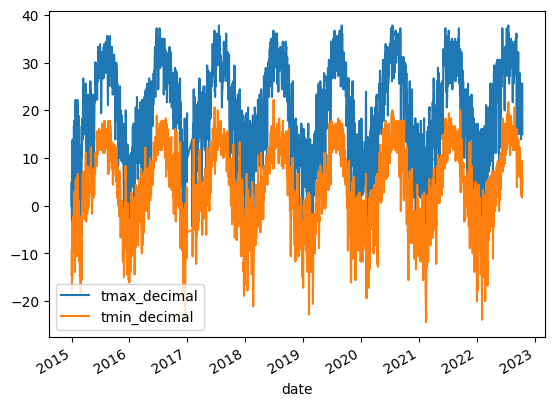

In [75]:
df.plot(y=["tmax_decimal", "tmin_decimal"])

Just mess around

In [80]:
df.describe()



,tmax,tmin,day_of_year,tmax_decimal,tmin_decimal
count,2815.000000,2815.000000,2815.000000,2815.000000,2815.000000
mean,196.656128,36.276199,181.067851,19.665613,3.627620
std,101.908145,85.060145,103.224137,10.190815,8.506015
min,-156.000000,-244.000000,1.000000,-15.600000,-24.400000
25%,122.000000,-28.000000,92.000000,12.200000,-2.800000
50%,206.000000,39.000000,180.000000,20.600000,3.900000
75%,283.000000,111.000000,268.000000,28.300000,11.100000
max,378.000000,222.000000,366.000000,37.800000,22.200000
